# The Implementation of AE, VAE and GAN
This implementation includes the theoritical explanation and training performance of three different kinds of generative deep learning models, that is, Autoencoder, Variational Autoencoder and Generative Adversarial Network on MNIST dataset. 

The questions will be covered are:
* Autoencoder: model introduction and implementation
* Variational Autoencoder: model introduction and implementation, theoritical explamentation
* The difference between Autoencoder and Variational Autoencoder
* Generative Adversarial Network: model introduction and implementation

**Note**: Models are created in Keras

## Part 1:  Autoencoder

#### Preparing:  Import TensorFlow and other libraries

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from keras.datasets import mnist
import numpy as np
from keras import backend 
from keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout, Lambda,  UpSampling2D
from keras.models import Model
from keras.layers import Conv2DTranspose, Reshape,Activation, LeakyReLU, Dropout
from keras.optimizers import Adam, RMSprop
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
from plot import *
import datetime
import cv2

from IPython.display import display, Image, SVG

import warnings
warnings.filterwarnings('ignore')

#### Preparing:  Load the MNIST dataset
There are 60,000 MNIST image totally in the train set and 10,000 MNIST image totally in the test set. Each MNIST image is originally with shape (28, 28), each of which is between 0-255 and represents the intensity of a pixel. We normalize the images to the range (0, 1) and reshape them to (28, 28, 1)

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

#### Preparing: the CallBack to save the training results

In [5]:
class CustomCallback(Callback):
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, decoder, z_dim ):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.decoder = decoder
        self.z_dim = z_dim
        
    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.z_dim))
            reconst = self.decoder.predict(np.array(z_new))[0].squeeze()
            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)
                
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1
    
         
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return new_lr
    
    return LearningRateScheduler(schedule)

### Introduction
A neural network made up of two parts:
* Encoder: compresses high-dimensional input data into a lower-dimensional representation vector
* Decoder: decompresses a given representation vector back to the original domain

![A diagram of a generator and discriminator](image/AEmodel.png)


Features of Autoencoder: 
* Lossy: the decompressed outputs will be degraded compared to the original inputs;
* nonlinear compress, comparing with PCA;
* Learning automatically from data examples, (self-supervised technique);
* Data-specific: they will only be able to compress data similar to what they have been trained on. For example:  An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific; ( This makes Autoencoder generally impractical for real-world data compression problems: only use them on data that is similar to what they were trained on, and making them more general thus requires lots of training data.)

Applications:
* data denoising: mapping noisy digits images to clean digits images.
* dimensionality reduction for data visualization

#### Training: 
There are three elements in the training:
* An encoding function (parametric functions), such as neural networks. **Be differentiable with respect to the distance function**, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss by using **Stochastic Gradient Descent**;
* A decoding function: with the same features as the encoding functions;
* A distance function ("loss" function) of the amount of information loss between the original representation and the reconstruction representation: want to minimize in the training. 


### Implementation of AE
#### Parameters for training

In [6]:
# run folder
SECTION = 'self_vae'
AE_RUN_ID = '0001'
AE_DATA_NAME = 'digits'
AE_RUN_FOLDER = 'run/{}/'.format(SECTION)
AE_RUN_FOLDER += '_'.join([AE_RUN_ID, AE_DATA_NAME])      

if not os.path.exists(AE_RUN_FOLDER):
    os.makedirs(AE_RUN_FOLDER)
    os.makedirs(os.path.join(AE_RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(AE_RUN_FOLDER, 'weights'))
    os.makedirs(os.path.join(AE_RUN_FOLDER, 'images'))
    
# parameters of encoder
input_dim = (28, 28, 1)  # the shape of input image
z_dim = 2 # the dimension of latent space 

encoder_conv_filters = [32, 64, 64, 64]
encoder_conv_kernel_size = [3,3,3,3]
encoder_conv_strides = [1,2,2,1]
n_layers_encoder = len(encoder_conv_filters)

# parameters of decoder:
decoder_conv_filters = [64, 64, 32, 1]
decoder_conv_kernel_size = [3,3,3,3]
decoder_conv_t_strides = [1,2,2,1]
n_layers_decoder = len(decoder_conv_filters)

# learning rate for optimizer
learning_rate = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0
    
# the number of random selected picture to show 
rand_selec_n_to_show = 10

# distribution
n_to_show = 5000
grid_size = 15
figsize = 7

####  Build the Encoder for MNIST
* input: the images
* output: 2D latent space

The process:
1. Create input layer;
* Pass through four Conv2D layers in sequence; (using stride of 2 on some of the layers to reduce the size of the output)
* Plattened the last convolutional layer;
* Connected to a Dense layer of size 2, which is the two-dimensional latent space. 

#### Build the Decoder
* input: 2D latent space
* output: original images domain 

The process: 
1. Create input layer;
2. Connect the input to a Dense layer and reshape;
3. Stack convolutional transpose layers;

#### Joining the Encoder and Decoder
Takes an image and pass it through the encoder and back out through the decoder to generate a reconstruction
* input: the same as the input to the encoder
* output: the output from the encoder passed through the decoder

In [7]:
encoder_input = Input(shape = input_dim, name = "Input_Encoder")
x = encoder_input 
for i in np.arange(0, n_layers_encoder):
    conv_layer = Conv2D(filters = encoder_conv_filters[i], 
                       kernel_size = encoder_conv_kernel_size[i],
                       strides = encoder_conv_strides[i],
                       padding = "same",
                       name = "encoder_conv_"+str(i+1))
    x = conv_layer(x)
    # x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # x = Dropout(rate = 0.25)(x)
shape_before_flattening = backend.int_shape(x)[1:]
#print("shape before flatten: {}".format(shape_before_flattening))
x = Flatten()(x)
encoder_output = Dense(z_dim, name = "Output_Encoder")(x)
encoder = Model(encoder_input, encoder_output)
#encoder.summary()

# build the decoder: 
# double the width and height of the tensor at each layer using Cov2DTranspose layers with stride 2
decoder_input = Input(shape = (z_dim,), name = "Input_Decoder")
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
for i in np.arange(0, n_layers_decoder):
    cont_t_layer = Conv2DTranspose(filters = decoder_conv_filters[i], 
                                  kernel_size = decoder_conv_kernel_size[i], 
                                  strides = decoder_conv_t_strides[i], 
                                  padding = "same", 
                                  name = "decoder_conv_t_"+str(i+1))
    x = cont_t_layer(x)
    if i < n_layers_decoder -1:
        x = LeakyReLU()(x)
    else:
        x = Activation("sigmoid")(x)
decoder_output = x
decoder = Model(decoder_input, decoder_output)
# decoder.summary()

model_input = encoder_input
model_output = decoder(encoder_output)
model = Model(model_input, model_output)

W1107 13:18:09.436358 140073648453440 deprecation_wrapper.py:119] From /home/zhuangby/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1107 13:18:09.467997 140073648453440 deprecation_wrapper.py:119] From /home/zhuangby/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1107 13:18:09.490992 140073648453440 deprecation_wrapper.py:119] From /home/zhuangby/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



#### Model compile 
Loss function: 
* MSE: reconstruction loss: the loss between images and their reconstruction images, place heavier penalties on predictions at the extremes that are badly wrong.

In [8]:
optimizer = Adam(lr = learning_rate)
#loss function
def l_loss(y_true, y_pred):
    return backend.mean(backend.square(y_true - y_pred), axis = [1,2,3])

model.compile(optimizer = optimizer, loss = l_loss, metrics=['accuracy'])

custom_callback = CustomCallback(AE_RUN_FOLDER, 2000, INITIAL_EPOCH,decoder, z_dim )
lr_sched = step_decay_schedule(initial_lr = learning_rate, decay_factor= 1, step_size=1)

checkpoint2 = ModelCheckpoint(os.path.join(AE_RUN_FOLDER, 'weights/weights.h5'), save_weights_only = True, verbose=1)
callbacks_list = [checkpoint2, custom_callback, lr_sched]

model.fit(     
    x_train
    , x_train
    , batch_size = BATCH_SIZE
    , shuffle = True
    , epochs = 1
    , initial_epoch = INITIAL_EPOCH
    , callbacks = callbacks_list
)

W1107 13:18:15.715698 140073648453440 deprecation_wrapper.py:119] From /home/zhuangby/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1107 13:18:15.877911 140073648453440 deprecation_wrapper.py:119] From /home/zhuangby/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1107 13:18:16.117382 140073648453440 deprecation_wrapper.py:119] From /home/zhuangby/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/1
60000/60000 [==============================] - 25s 414us/step - loss: 0.0556 - acc: 0.7966

Epoch 00001: saving model to run/self_vae/0001_digits/weights/weights.h5


#### Result:
Comparing the original image and reconstructed image from autoencoder, the top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of details with this basic approach.

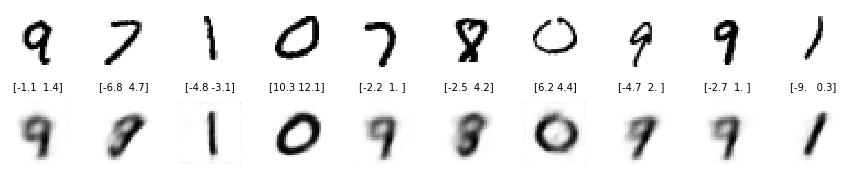

In [12]:
model.load_weights(os.path.join(AE_RUN_FOLDER, 'weights/weights.h5'))

# select the test data randomly and plot 
example_idx = np.random.choice(range(len(x_test)), rand_selec_n_to_show)
example_images = x_test[example_idx]
z_points = encoder.predict(example_images)
reconst_images = decoder.predict(z_points)
plot_select(z_points, example_images, reconst_images, rand_selec_n_to_show)

#### Explore the latent layer
The autoencoders has grouped digits that look alike into the same part of the latent space. 
Few comments: 
1. large gaps


The problems are caused: 
1. choosing a random point in the latent space is problematic 
2. some reconstructed images are poorly formed 

The distribution of different digits in latent space


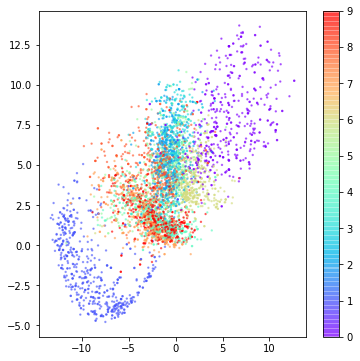

The normalized distribution with embedded digit number in latent space
Random sampling some points from latent space


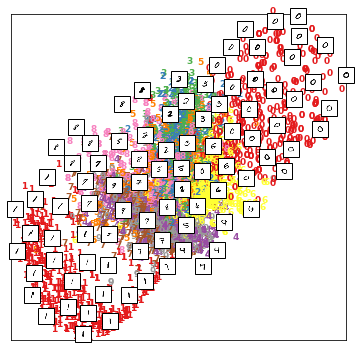

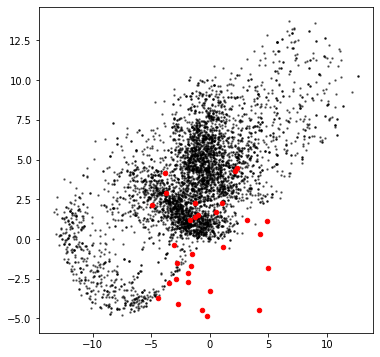

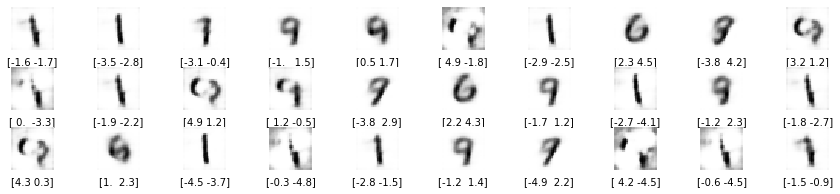

In [14]:
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

# the latent layer 
z_points = encoder.predict(example_images)
print("The distribution of different digits in latent space")
plot_latent_distribution(z_points, example_labels)

# Normalized the axis to show the distribution 
print("The normalized distribution with embedded digit number in latent space")
plot_embedding(z_points, example_images, example_labels)
# Random sampling some points
print("Random sampling some points from latent space")
Plot_sampling(z_points, decoder)

# The overall latent space distribution 
#print("The overall distritbuion with digits in latent space")
#plot_latentspace(z_points, example_labels, decoder)